<h1> Normalizing input of the neural network </h1>
$\newline$
started: 15/2/2023 $\newline$
finished:15/2/2023


**Aim:** better performance by normalizing the input of NN. 

In [7]:
import myfunctions_old as mf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
from scipy.optimize import curve_fit

In [2]:
# load data
rootfile = uproot.open("./stage1_clusters_bigdata.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [4]:
# cut data into right shape as in "SimplestNetwork"

xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit)

In [5]:
# create input data
clusters5x5, coord, x_edge, y_edge = mf.form_cluster(xMC_train, yMC_train, EMC_train)

This took  369.45560908317566 s


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/stage1/myfunctions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return arr_cluster, np.array(c_sys), np.array(edge_x), np.array(edge_y)


<h2> idea 1 - standard score (z-score) </h2>

The first idea of standardization is using $x' = \frac{x- \mu}{\sigma}$ over all data.

In [40]:
def prep_clusters_standardscore(cluster):
    '''input should be 5x5 clusters, returns z-score/standart score of reshaped clusters'''

    cluster = cluster.reshape((cluster.shape[0], 25))
    mu = np.mean(cluster)
    sigma = np.std(cluster) 
    return (cluster - mu ) / sigma

In [20]:
cluster = prep_clusters_standardscore(clusters5x5)
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord)

But now we have data from -1 to 6! As the values are also negative now, relu might be the wrong option. Use leaky relu instead. 

Mean:  -1.2083730697723152e-17
Standard deviation:  1.000000000000002


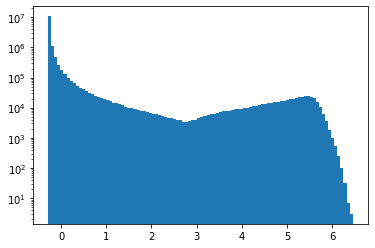

In [13]:
plt.hist(cluster.flatten(), bins=100)
print("Mean: ", np.mean(cluster))
print("Standard deviation: ", np.std(cluster))
plt.yscale("log")

<h3> The network

In [18]:
model_zscore = keras.Sequential([layers.Input(shape=(25)),
                         layers.Dense(64, activation=keras.layers.LeakyReLU()),
                         layers.Dense(128, activation=keras.layers.LeakyReLU()),
                         layers.Dense(256, activation=keras.layers.LeakyReLU()),
                         layers.Dense(128, activation=keras.layers.LeakyReLU()),
                         layers.Dense(64, activation=keras.layers.LeakyReLU()),
                         layers.Dense(32, activation=keras.layers.LeakyReLU()),
                         layers.Dense(3, activation=None)])
model_zscore.summary()
model_zscore.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 3)                

In [21]:
fit_hist = model_zscore.fit(cluster, training, batch_size=50, epochs=50, validation_split=0.1)

Epoch 1/50
10353/10353 [==============================] - 39s 4ms/step - loss: 20.4770 - val_loss: 1.0994
Epoch 2/50
10353/10353 [==============================] - 35s 3ms/step - loss: 1.0261 - val_loss: 1.0887
Epoch 3/50
10353/10353 [==============================] - 32s 3ms/step - loss: 0.7881 - val_loss: 0.5333
Epoch 4/50
10353/10353 [==============================] - 35s 3ms/step - loss: 0.5232 - val_loss: 0.4345
Epoch 5/50
10353/10353 [==============================] - 38s 4ms/step - loss: 0.4159 - val_loss: 0.5315
Epoch 6/50
10353/10353 [==============================] - 35s 3ms/step - loss: 0.3504 - val_loss: 0.2890
Epoch 7/50
10353/10353 [==============================] - 35s 3ms/step - loss: 0.3247 - val_loss: 0.2912
Epoch 8/50
10353/10353 [==============================] - 34s 3ms/step - loss: 0.2947 - val_loss: 0.2757
Epoch 9/50
10353/10353 [==============================] - 34s 3ms/step - loss: 0.2779 - val_loss: 0.2113
Epoch 10/50
10353/10353 [=============================

In [24]:
def training_vs_validation_loss(fit_hist, log=True):
    plt.plot(fit_hist.history['loss'])
    plt.plot(fit_hist.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(["Training Loss", "Validation Loss"])
    if log==True:
        plt.yscale('log')
    plt.show()

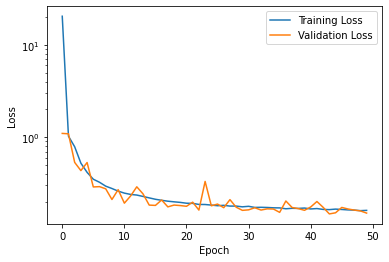

In [25]:
training_vs_validation_loss(fit_hist)

<h3> Test on data...

In [26]:
# make data to test the net on
clusters5x5_v, coord_v, x_edge_v, y_edge_v = mf.form_cluster(xMC_veri, yMC_veri, EMC_veri)
clusters_v = clusters5x5_v.reshape((clusters5x5_v.shape[0], 25))

This took  94.82942008972168 s


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/stage1/myfunctions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return arr_cluster, np.array(c_sys), np.array(edge_x), np.array(edge_y)


In [41]:
output_zscore = model_zscore.predict(prep_clusters_standardscore(clusters_v))

In [29]:
# prep data
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

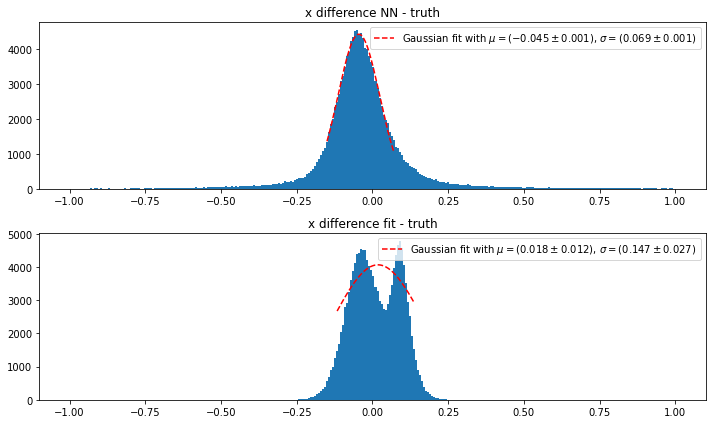

(array([-4.50666677e-02,  6.85180783e-02,  7.58208827e+02]),
 array([6.05141086e-04, 7.89346532e-04, 7.04458089e+00]),
 array([1.81612812e-02, 1.47285350e-01, 1.50095888e+03]),
 array([1.16233842e-02, 2.74563407e-02, 2.33778821e+02]))

In [42]:
mf.histo_output(output_zscore.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", bins=300)

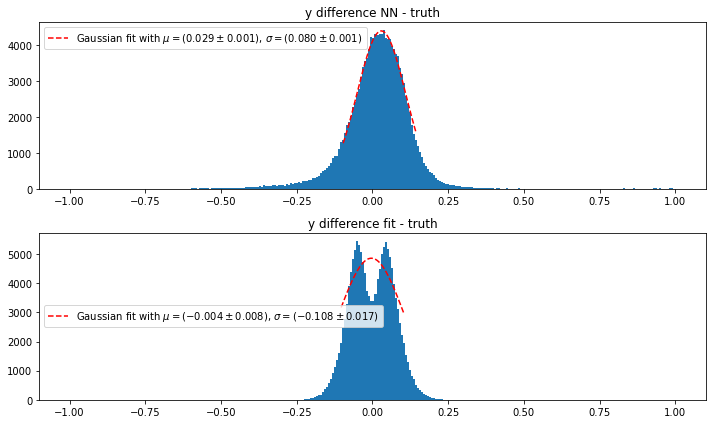

(array([2.91917163e-02, 8.00767722e-02, 8.82462119e+02]),
 array([6.57117381e-04, 9.05794418e-04, 7.96892545e+00]),
 array([-3.59438292e-03, -1.07906289e-01,  1.31565630e+03]),
 array([7.84213127e-03, 1.66472602e-02, 1.65005395e+02]))

In [45]:
mf.histo_output(output_zscore.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

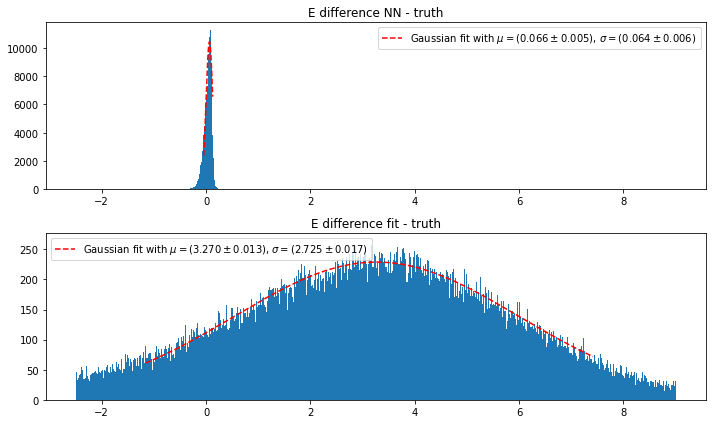

(array([6.56784258e-02, 6.42846078e-02, 1.68280910e+03]),
 array([4.51777697e-03, 5.97296514e-03, 1.28529585e+02]),
 array([   3.2696807 ,    2.72493759, 1563.25655929]),
 array([0.01290007, 0.01738669, 7.99624942]))

In [43]:
mf.histo_output(output_zscore.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-2.5,9), bins=1000)

In comparison to the simplest NN $\mu$ got smaller by a factor of 2

<h2> idea 2 - c score with relu </h2>

Try the same as above but with relu as activation function

In [72]:
model_zscore_relu = keras.Sequential([layers.Input(shape=(25)),
                         layers.Dense(64, activation=keras.layers.LeakyReLU()),
                         layers.Dense(128, activation=keras.layers.LeakyReLU()),
                         layers.Dense(256, activation=keras.layers.LeakyReLU()),
                         layers.Dense(128, activation=keras.layers.LeakyReLU()),
                         layers.Dense(64, activation=keras.layers.LeakyReLU()),
                         layers.Dense(32, activation=keras.layers.LeakyReLU()),
                         layers.Dense(3, activation=None)])
model_zscore_relu.summary()
model_zscore_relu.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_25 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 3)                

In [73]:
fit_hist = model_zscore_relu.fit(cluster, training, batch_size=50, epochs=50, validation_split=0.1)

Epoch 1/50
10353/10353 [==============================] - 28s 3ms/step - loss: 24.5927 - val_loss: 1.0177
Epoch 2/50
10353/10353 [==============================] - 26s 2ms/step - loss: 1.0058 - val_loss: 0.9647
Epoch 3/50
10353/10353 [==============================] - 25s 2ms/step - loss: 0.8217 - val_loss: 0.5844
Epoch 4/50
10353/10353 [==============================] - 27s 3ms/step - loss: 0.5900 - val_loss: 0.4116
Epoch 5/50
10353/10353 [==============================] - 25s 2ms/step - loss: 0.4339 - val_loss: 0.3708
Epoch 6/50
10353/10353 [==============================] - 27s 3ms/step - loss: 0.3607 - val_loss: 0.3777
Epoch 7/50
10353/10353 [==============================] - 25s 2ms/step - loss: 0.3238 - val_loss: 0.3092
Epoch 8/50
10353/10353 [==============================] - 25s 2ms/step - loss: 0.2963 - val_loss: 0.2764
Epoch 9/50
10353/10353 [==============================] - 24s 2ms/step - loss: 0.2797 - val_loss: 0.2349
Epoch 10/50
10353/10353 [=============================

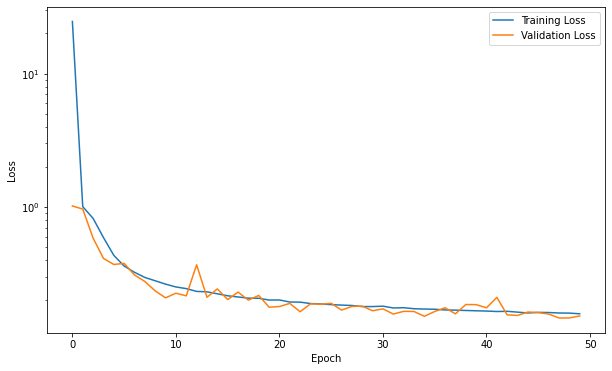

In [74]:
training_vs_validation_loss(fit_hist)

In [75]:
output_zscore_relu = model_zscore_relu.predict(prep_clusters_standardscore(clusters_v))

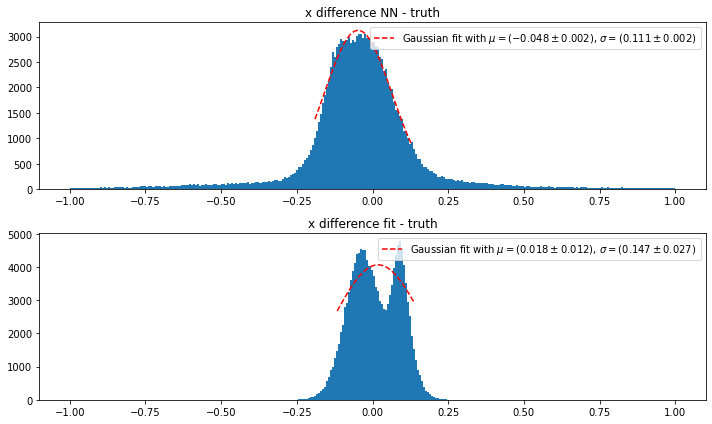

(array([-4.76865345e-02,  1.11170492e-01,  8.69768474e+02]),
 array([1.54685144e-03, 2.22905158e-03, 1.38648006e+01]),
 array([1.81612812e-02, 1.47285350e-01, 1.50095888e+03]),
 array([1.16233842e-02, 2.74563407e-02, 2.33778821e+02]))

In [77]:
mf.histo_output(output_zscore_relu.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", bins=300)

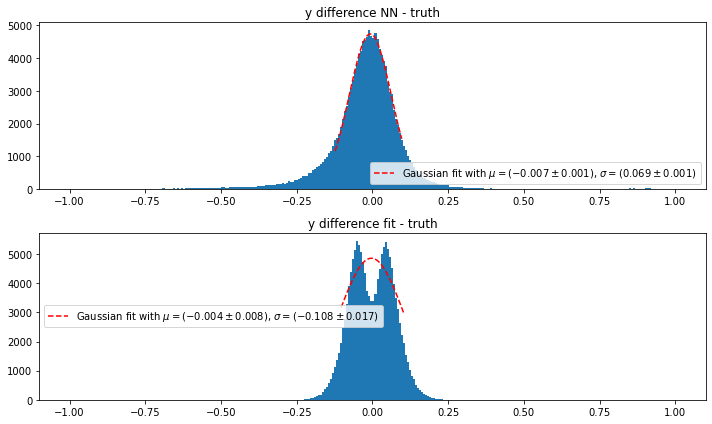

(array([-7.25604711e-03,  6.92984926e-02,  8.22534712e+02]),
 array([5.44082935e-04, 7.18518197e-04, 6.85834087e+00]),
 array([-3.59438292e-03, -1.07906289e-01,  1.31565630e+03]),
 array([7.84213127e-03, 1.66472602e-02, 1.65005395e+02]))

In [78]:
mf.histo_output(output_zscore_relu.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

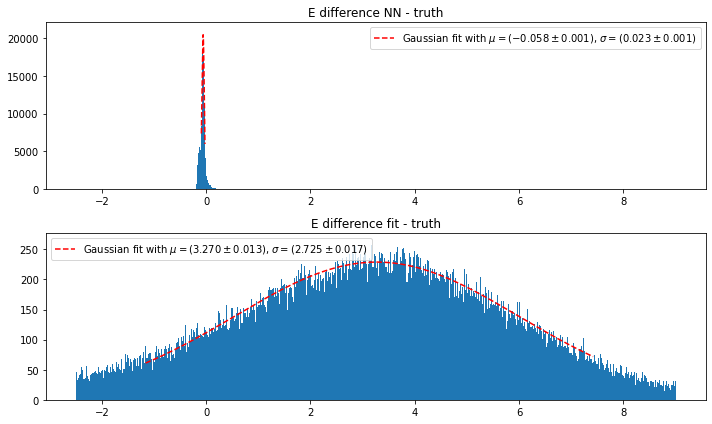

(array([-5.78500783e-02,  2.30345850e-02,  1.17928418e+03]),
 array([7.62691710e-04, 9.62993044e-04, 4.00249140e+01]),
 array([   3.2696807 ,    2.72493759, 1563.25655929]),
 array([0.01290007, 0.01738669, 7.99624942]))

In [79]:
mf.histo_output(output_zscore_relu.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-2.5,9), bins=1000)

<h2> idea 3 - normalization to largest value </h2>
    As I don't want negative values, try to normalize the data between 0 and 1. 

In [62]:
def prep_clusters_norm(cluster, maxval=140):
    cluster = cluster.reshape((cluster.shape[0], 25))
    return cluster / maxval

In [64]:
cluster_norm = prep_clusters_norm(clusters5x5)

I will use the simple NN with relu activation as in 'SimplestNN'

In [48]:
model_norm = keras.Sequential([layers.Input(shape=(25)),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model_norm.summary()
model_norm.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 3)                

In [65]:
fit_hist = model_norm.fit(cluster_norm, training, batch_size=50, epochs=50, validation_split=0.1)

Epoch 1/50
10353/10353 [==============================] - 25s 2ms/step - loss: 0.5725 - val_loss: 0.3184
Epoch 2/50
10353/10353 [==============================] - 24s 2ms/step - loss: 0.2730 - val_loss: 0.2140
Epoch 3/50
10353/10353 [==============================] - 23s 2ms/step - loss: 0.2080 - val_loss: 0.1874
Epoch 4/50
10353/10353 [==============================] - 23s 2ms/step - loss: 0.1899 - val_loss: 0.1851
Epoch 5/50
10353/10353 [==============================] - 23s 2ms/step - loss: 0.1782 - val_loss: 0.1823
Epoch 6/50
10353/10353 [==============================] - 23s 2ms/step - loss: 0.1716 - val_loss: 0.1704
Epoch 7/50
10353/10353 [==============================] - 23s 2ms/step - loss: 0.1658 - val_loss: 0.1671
Epoch 8/50
10353/10353 [==============================] - 23s 2ms/step - loss: 0.1603 - val_loss: 0.1554
Epoch 9/50
10353/10353 [==============================] - 23s 2ms/step - loss: 0.1555 - val_loss: 0.1511
Epoch 10/50
10353/10353 [==============================

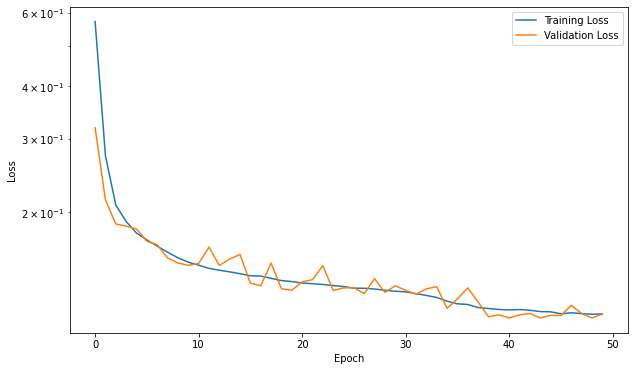

In [71]:
training_vs_validation_loss(fit_hist)

validation loss is a bit jumpy... -> smaler learning rate?

In [66]:
output_norm = model_norm.predict(prep_clusters_norm(clusters_v))

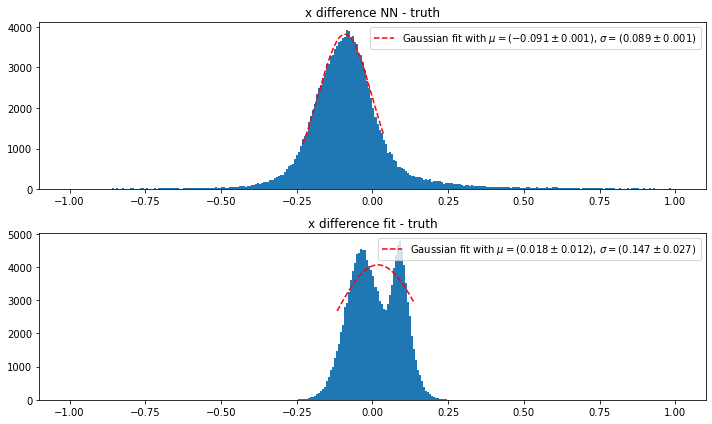

(array([-9.08356484e-02,  8.85223979e-02,  8.46611826e+02]),
 array([9.08575159e-04, 1.24769651e-03, 9.53062386e+00]),
 array([1.81612812e-02, 1.47285350e-01, 1.50095888e+03]),
 array([1.16233842e-02, 2.74563407e-02, 2.33778821e+02]))

In [67]:
mf.histo_output(output_norm.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", bins=300)

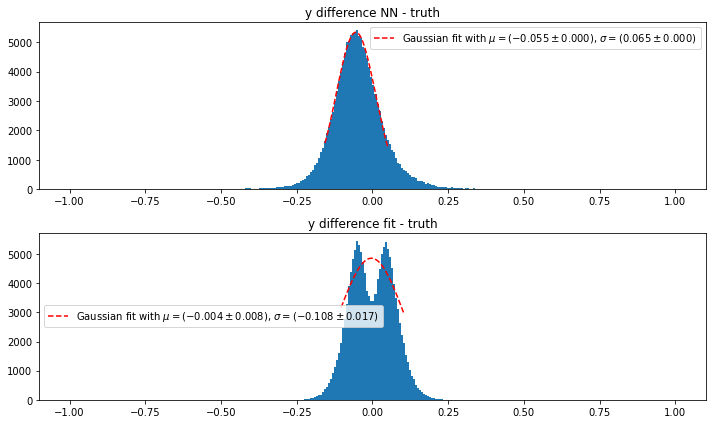

(array([-5.48577422e-02,  6.50481096e-02,  8.69685140e+02]),
 array([3.49580594e-04, 4.60677914e-04, 4.95345232e+00]),
 array([-3.59438292e-03, -1.07906289e-01,  1.31565630e+03]),
 array([7.84213127e-03, 1.66472602e-02, 1.65005395e+02]))

In [69]:
mf.histo_output(output_norm.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

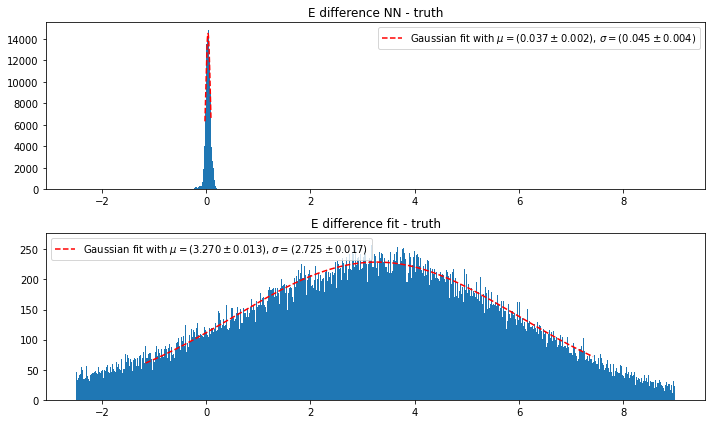

(array([3.66266439e-02, 4.52963864e-02, 1.64638112e+03]),
 array([2.48397245e-03, 3.75460069e-03, 1.07667579e+02]),
 array([   3.2696807 ,    2.72493759, 1563.25655929]),
 array([0.01290007, 0.01738669, 7.99624942]))

In [70]:
mf.histo_output(output_norm.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-2.5,9), bins=1000)

In [80]:
# save models
#keras.models.save_model(model_zscore, 'stage1_zscore_leakyrelu')
#keras.models.save_model(model_zscore_relu, 'stage1_zscore_relu')
#keras.models.save_model(model_norm, 'stage1_norm_relu')

INFO:tensorflow:Assets written to: stage1_zscore_leakyrelu/assets


INFO:tensorflow:Assets written to: stage1_zscore_leakyrelu/assets


INFO:tensorflow:Assets written to: stage1_zscore_relu/assets


INFO:tensorflow:Assets written to: stage1_zscore_relu/assets


INFO:tensorflow:Assets written to: stage1_norm_relu/assets


INFO:tensorflow:Assets written to: stage1_norm_relu/assets


<h1> summary </h1>

| (x/y/E) | $\mu$ | $\sigma$ |
| --- | --- | --- |
| simplest model | 0.107 / 0.070 / 0.081 | 0.071 / 0.066 / 0.054 |
| z score & leaky relu | 0.045 / 0.029 / 0.066| 0.069 / 0.080 / 0.064 |
| z score & relu |0.048 / 0.007 / 0.058| 0.111 / 0.069 / 0.023|
| normalization (devision by largest value) | 0.091 / 0.055 / 0.037| 0.089 / 0.065 / 0.045|